# Local Quantile Projections: Example

This notebook presents a (simple) application of local quantile projections

It uses a Python package that I have written, quantileproj.py, also available in this Github folder (modules/). quantileproj is based on the Quantreg modules of statsmodels. The package also relies on my conditional quantile sampling module (https://github.com/romainlafarguette/cqsampling)

The quantile uncrossing part is based on either:

Chernozhukov et al. (2010) Quantile and Probability Curves Without Crossing, Econometrica

Schmidt and Zhu (2016), Quantile Spacings: A Simple Method for the Joint Estimation of Multiple Quantiles Without Crossing

Author: Romain Lafarguette, August 2020, https://github.com/romainlafarguette

If you have any question, please contact me via Github 

## Preamble

In [43]:
# Main packages
import os, sys, importlib                               # System tools
import pandas as pd                                     # Dataframes
import numpy as np                                      # Numeric tools
import statsmodels.api as sm                            # Statistics

# Graphics
%matplotlib inline
import matplotlib.pyplot as plt                         # Graphical package  
import seaborn as sns                                   # Graphical tools
plt.rcParams["figure.figsize"]=25,15 

# Local modules
sys.path.append(os.path.abspath('modules'))             # Executable path
import quantileproj; importlib.reload(quantileproj)     # Quantile projections
from quantileproj import QuantileProj

## Parameters

In [44]:
quantile_l = list(np.arange(0.05, 1, 0.05)) # Every 5% quantiles (put less if you have "bad data")
horizon_l = [1, 2, 4, 8, 12] # 1Q - 2Q, 1Y, 2Y, 3Y for quarterly data

## Example data set (US macro data from statsmodels)

In [45]:
df = sm.datasets.macrodata.load_pandas().data.copy()

# Create a date index with end of quarter convention
dates_l = [f'{y:.0f}-Q{q:.0f}' for y,q in zip(df['year'], df['quarter'])]
df = df.set_index(pd.to_datetime(dates_l) + pd.offsets.QuarterEnd())

# Clean some variables
df['rgdp_growth'] = df['realgdp'].rolling(4).sum().pct_change(4)
df = df.rename(columns={'infl':'inflation', 'unemp':'unemployment'})


## Quantile model specification and fit

In [46]:
dependent = 'inflation'
regressors_l = ['rgdp_growth', 'unemployment', 'realint']

qr = QuantileProj(dependent, regressors_l, df, horizon_l)

qr_fit = qr.fit(quantile_l=quantile_l, alpha=0.05)

7 missing obs on depvar and indvar
95 quantile regressions estimated for 5 horizons and 19 quantiles


### All the coefficients, tstats, pvalues and R2 are packaged into a large dataframe

In [47]:
qr_fit.coeffs

,tau,horizon,coeff,tval,pval,lower_ci,upper_ci,pseudo_r2
Intercept,0.05,1,0.832781,0.534351,0.593720,-2.241282,3.906843,0.011418
rgdp_growth,0.05,1,11.034278,0.614753,0.539449,-24.369669,46.438225,0.011418
unemployment,0.05,1,-0.223963,-1.038117,0.300528,-0.649501,0.201575,0.011418
realint,0.05,1,0.125237,0.948204,0.344224,-0.135282,0.385757,0.011418
Intercept,0.10,1,-1.823767,-1.917015,0.056728,-3.700285,0.052750,0.007620
...,...,...,...,...,...,...,...,...
realint,0.90,12,-0.737268,-2.576350,0.010787,-1.301943,-0.172593,0.167645
Intercept,0.95,12,2.701342,0.706339,0.480891,-4.845135,10.247819,0.200185
rgdp_growth,0.95,12,-16.206522,-0.464272,0.643014,-85.086839,52.673794,0.200185
unemployment,0.95,12,1.400861,2.631677,0.009234,0.350496,2.451226,0.200185


## Local projections based on conditioning vector

In [48]:
# Design a conditioning vector (here last observation for instance)
cond_frame = df.loc[[max(df.index)], regressors_l].copy()
qr_proj = qr_fit.proj(cond_frame)

### The fitted conditional quantiles are available in the object directly, with the asymptotics and sampled statistics

In [49]:
qr_proj.cond_quant

,tau,horizon,conditional_quantile_mean,conditional_quantile_mean_se,conditional_quantile_mean_ci_lower,conditional_quantile_mean_ci_upper,conditional_quantile_obs_ci_lower,conditional_quantile_obs_ci_upper
0,0.05,1,-2.065469,1.245208,-4.521595,0.390657,-5.215574,1.084636
1,0.10,1,2.403130,0.806069,0.813190,3.993070,-0.130349,4.936609
2,0.15,1,2.391406,0.831779,0.750755,4.032058,-0.174202,4.957014
3,0.20,1,2.319385,0.712495,0.914016,3.724753,-0.102529,4.741299
4,0.25,1,3.646108,0.672772,2.319092,4.973125,1.268803,6.023414
...,...,...,...,...,...,...,...,...
90,0.75,12,11.260635,1.296870,8.701611,13.819659,8.029188,14.492081
91,0.80,12,11.912207,1.337178,9.273647,14.550767,8.617417,15.206997
92,0.85,12,12.105725,1.872121,8.411599,15.799851,7.917622,16.293828
93,0.90,12,16.170022,2.370452,11.492572,20.847472,11.093391,21.246652


### Plot the quantile coefficients and R2

In [54]:
import quantileproj; importlib.reload(quantileproj)     # Quantile projections
from quantileproj import QuantileProj

qr = QuantileProj(dependent, regressors_l, df, horizon_l)
qr_fit = qr.fit(quantile_l=quantile_l, alpha=0.05)


7 missing obs on depvar and indvar
95 quantile regressions estimated for 5 horizons and 19 quantiles


### Conditional quantiles plot (fitted from quantile regressions)

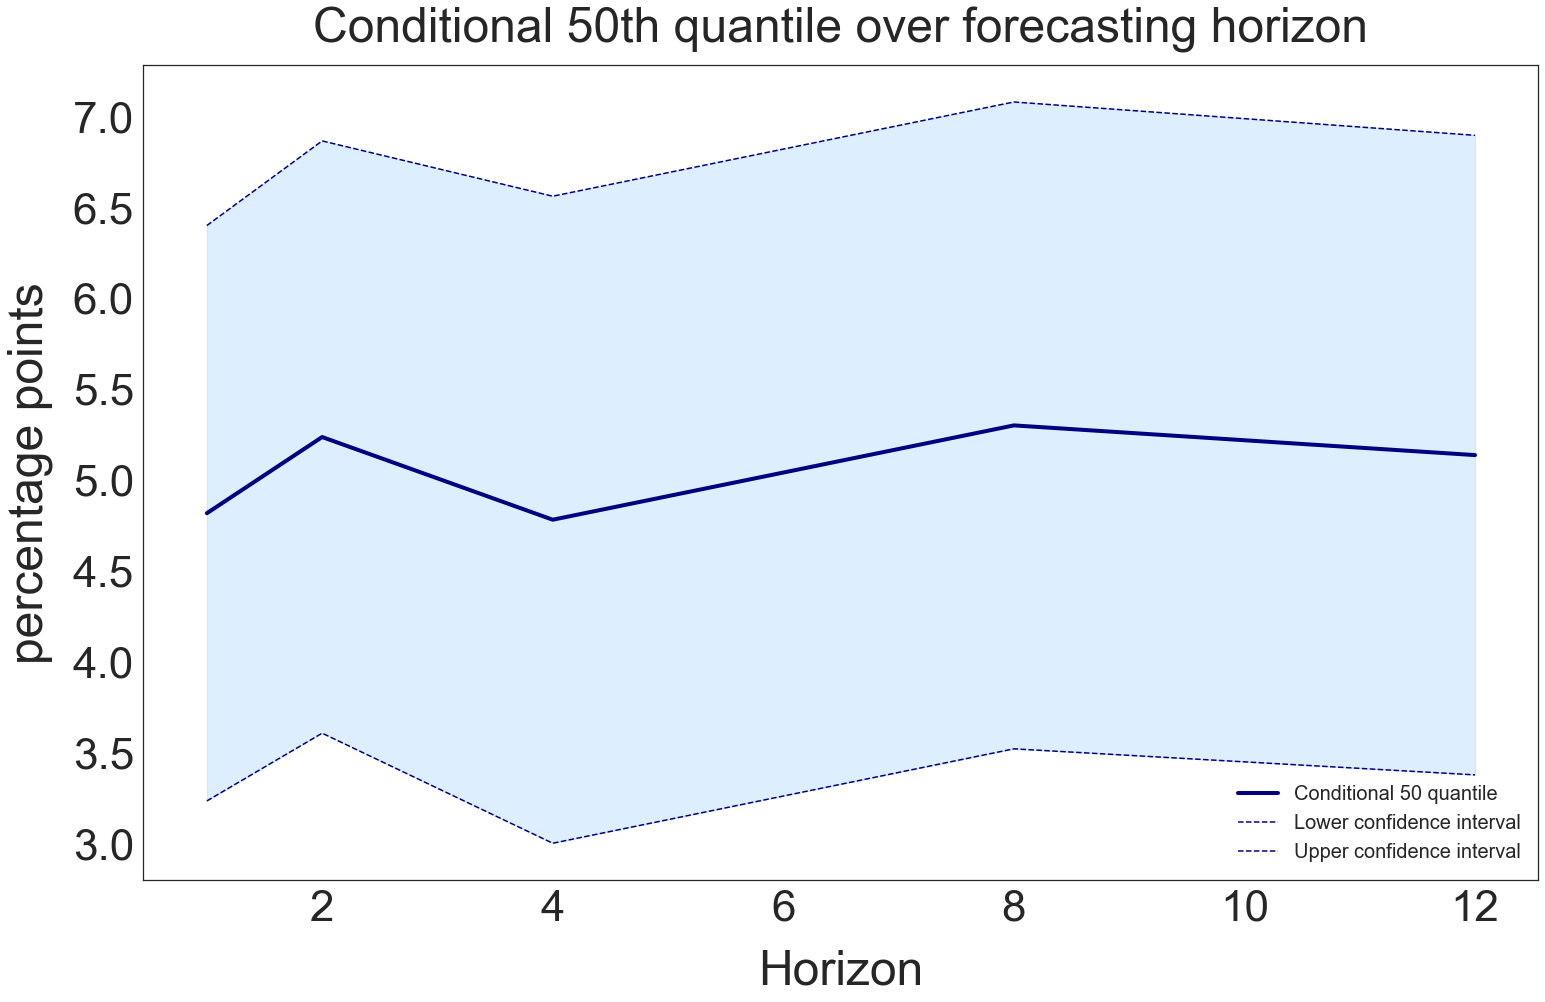

In [61]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial') # Style
qr_proj.plot.fitted_quantile(quantile=0.5, ylabel='percentage points', legendfont=20)
plt.show()

### Fan chart (based on resampled conditional quantiles)

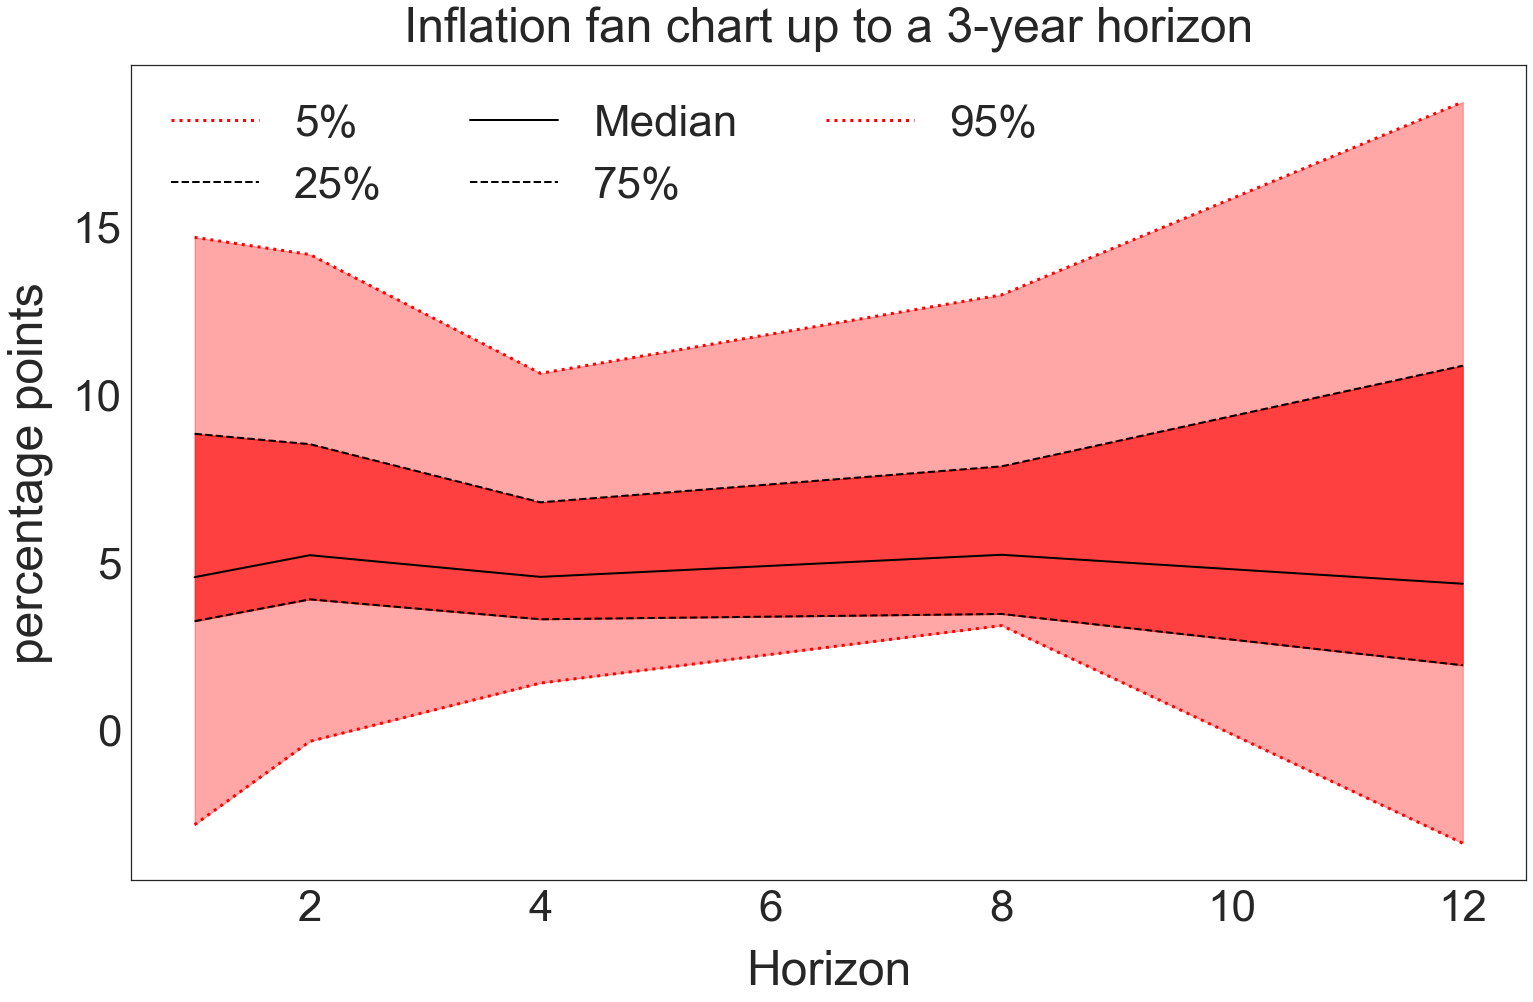

In [27]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial') # Style
qr_proj.plot.fan_chart(title='Inflation fan chart up to a 3-year horizon', ylabel='percentage points')
plt.show()

#### The file ends here